In [680]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as au
from astropy import constants as ac
from pathlib import Path
plt.style.use('/home/hmlee/smoon.mplstyle')

### Initial conditions

#### Surface density
$$
\Sigma = \Sigma_0 \left(\frac{R}{R_0}\right)^{-p}
$$
#### Velocity
Equilibrium velocity profile (taking into account pressure and self-gravity) is automatically computed inside the FARGO code.
#### Temperature
The sound speed profile (or temperature profile) is set by specifying the aspect ratio $H/R$, through
$$
c_s = v_k (H/R),
$$
assuming the vertical hydrostatic equilibrium.

$H/R$ is controlled by the Parameter `AspectRatio` $h_0$ and `FlaringIndex` $f$ such that
$$
\frac{H}{R} = h_0 (R/R_0)^f.
$$

### Unit System
* unit mass = mass of the central star
* unit length = arbitrary choice
* unit velocity = Keplerian velocity at the scale radius
* **Note that the unit velocity and therefore the unit time are not independent of the unit length**
* In this unit system, the Poisson equation reads $\nabla^2\Phi = 4\pi \rho$, i.e., $G=1$.

In [692]:
# set parameters

p = 1               # Power law index
q = 0.3             # M_d / M_*
Rin = 5*ac.au       # inner radius
Rout = 25*ac.au     # outer radius
Ms = 0.3*ac.M_sun   # mass of the central star
R0 = 1*ac.au        # arbitrary length unit
hor = 0.05          # disk aspect ratio H/r
fi = 2/7            # flaring index
mu = 1              # mean molecular weight
Gamma = 1.4         # adiabatic index

# dimensionless surface density
# normalized such that \int Sig0 dxdy = Md = q*Ms
Sig0 = ((2-p)/(2*np.pi)*q/((Rout/R0)**(2-p) - (Rin/R0)**(2-p))).value
print('Sigma0 = {}'.format(Sig0))

# code units
# unit mass = mass of the central star
# unit length = arbitrary choice
# unit velocity = Keplerian velocity at the scale radius
# ! note that the unit velocity and therefore the unit time are not independent of the unit length
umass = Ms.to('Msun')
ulength = R0.to('AU')
uvelocity = ((ac.G*Ms/R0)**0.5).to('km s-1')
utime = (ulength/uvelocity).to('yr')
utemp = (uvelocity**2/(ac.k_B/ac.m_p)).to('K')
usurf = (umass/ulength**2).to('g cm-2')

# other diagnostics
Torb = 2*np.pi*(Rout/R0)**1.5
print('orbital time at the inner radius = {:.0f}'.format(Torb*utime*(Rin/Rout)**1.5))
print('orbital time at the outer radius = {:.0f}'.format(Torb*utime))
print('orbital time at the outer radius (in code unit) = {}'.format(Torb))

Sigma0 = 0.0023873241463784303
orbital time at the inner radius = 20 yr
orbital time at the outer radius = 228 yr
orbital time at the outer radius (in code unit) = 785.3981633974482


# Run 1 : Equilibrium disk with self-gravity

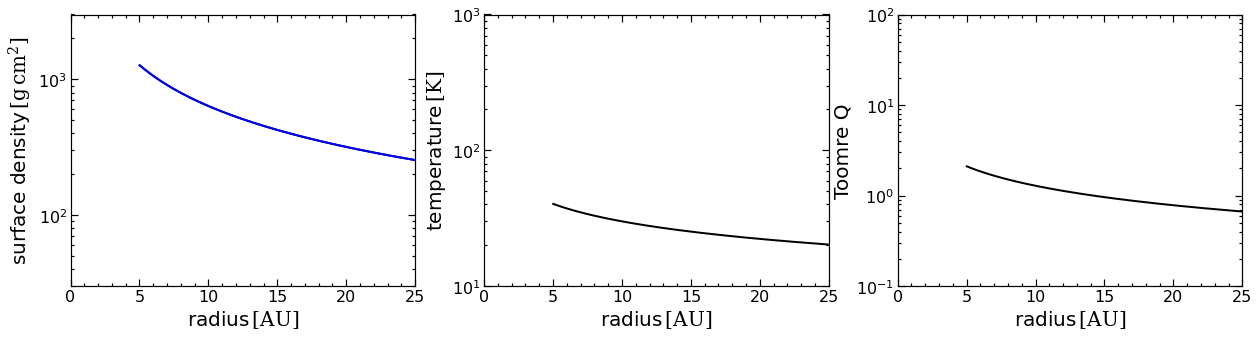

In [684]:
# read initial conditions

basedir = 'fargo-adsg/out1'

dims = np.loadtxt(Path(basedir,'dims.dat'))
Nrad, Nsec = int(dims[6]), int(dims[7])
Rf = np.loadtxt(Path(basedir,'used_rad.dat'))
Rc = 0.5*(Rf[:-1]+Rf[1:])
phif = np.linspace(0, 2*np.pi, Nsec+1)
phic = 0.5*(phif[:-1]+phif[:-1])

sig = np.fromfile(Path(basedir,'gasdens0.dat')).reshape(Nrad, Nsec)
vr = np.fromfile(Path(basedir,'gasvrad0.dat')).reshape(Nrad, Nsec)
vt = np.fromfile(Path(basedir,'gasvtheta0.dat')).reshape(Nrad, Nsec)
temp = np.fromfile(Path(basedir,'gasTemperature0.dat')).reshape(Nrad, Nsec)
energy = np.fromfile(Path(basedir,'gasenergy0.dat')).reshape(Nrad, Nsec)
Q = hor/np.pi/(Sig0*Rc**(2-p-fi))
vK = Rc**-0.5
cs = vK*hor*Rc**fi
T = (cs*uvelocity)**2*mu*ac.m_p/ac.k_B

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))

ax1.plot(Rc, sig[:,0]*(umass/ulength**2).to('g cm-2'))
ax1.plot(Rc, Sig0*(Rc)**-(p)*(umass/ulength**2).to('g cm-2'), 'b-')

ax1.set_yscale('log')
ax1.set_ylim(3e1, 3e3)
ax1.set_ylabel('surface density'+r'$\,[\mathrm{g\,cm^2}]$')


ax2.plot(Rc, temp[:,0]*utemp)
ax2.plot(Rc, T, 'b-')
ax2.set_yscale('log')
ax2.set_ylim(1e1, 1e3)
ax2.set_ylabel('temperature'+r'$\,[\mathrm{K}]$')

ax3.plot(Rc, Q)
ax3.set_ylabel('Toomre Q')
ax3.set_ylim(1e-1, 1e2)
ax3.set_yscale('log')

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(0, Rout/R0)
    ax.set_xlabel('radius'+r'$\,[\mathrm{AU}]$')

Text(0.5, 1.0, '3 orbit (at Rout)')

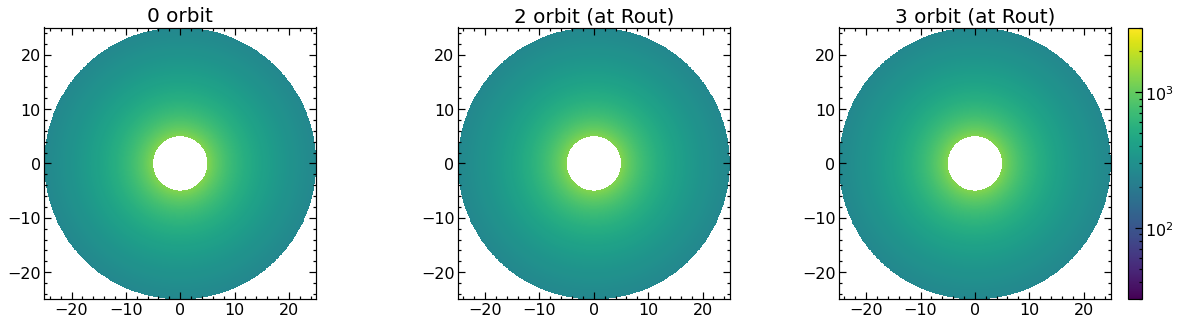

In [686]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
nums = [0, 20, 30]

for ax, num in zip((ax1, ax2, ax3), nums):
    sig = np.fromfile(Path(basedir,'gasdens{}.dat'.format(num))).reshape(Nrad, Nsec)
    theta, r = np.meshgrid(phif, Rf)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    img = ax.pcolormesh(x, y, sig*usurf, norm=LogNorm(3e1,3e3))
    ax.set_aspect('equal')
plt.colorbar(img)
ax1.set_title('0 orbit')
ax2.set_title('2 orbit (at Rout)')
ax3.set_title('3 orbit (at Rout)')

# Run 2 : With random density perturbations

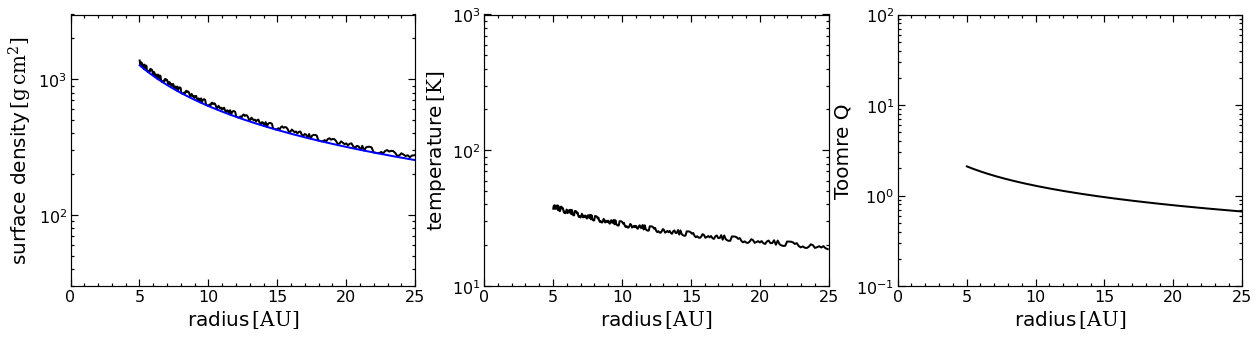

In [681]:
# read initial conditions

basedir = 'fargo-adsg/out2'

dims = np.loadtxt(Path(basedir,'dims.dat'))
Nrad, Nsec = int(dims[6]), int(dims[7])
Rf = np.loadtxt(Path(basedir,'used_rad.dat'))
Rc = 0.5*(Rf[:-1]+Rf[1:])
phif = np.linspace(0, 2*np.pi, Nsec+1)
phic = 0.5*(phif[:-1]+phif[:-1])

sig = np.fromfile(Path(basedir,'gasdens0.dat')).reshape(Nrad, Nsec)
vr = np.fromfile(Path(basedir,'gasvrad0.dat')).reshape(Nrad, Nsec)
vt = np.fromfile(Path(basedir,'gasvtheta0.dat')).reshape(Nrad, Nsec)
temp = np.fromfile(Path(basedir,'gasTemperature0.dat')).reshape(Nrad, Nsec)
energy = np.fromfile(Path(basedir,'gasenergy0.dat')).reshape(Nrad, Nsec)
Q = hor/np.pi/(Sig0*Rc**(2-p-fi))
vK = Rc**-0.5
cs = vK*hor*Rc**fi
T = (cs*uvelocity)**2*mu*ac.m_p/ac.k_B

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))

ax1.plot(Rc, sig[:,0]*(umass/ulength**2).to('g cm-2'))
ax1.plot(Rc, Sig0*(Rc)**-(p)*(umass/ulength**2).to('g cm-2'), 'b-')

ax1.set_yscale('log')
ax1.set_ylim(3e1, 3e3)
ax1.set_ylabel('surface density'+r'$\,[\mathrm{g\,cm^2}]$')


ax2.plot(Rc, temp[:,0]*utemp)
ax2.plot(Rc, T, 'b-')
ax2.set_yscale('log')
ax2.set_ylim(1e1, 1e3)
ax2.set_ylabel('temperature'+r'$\,[\mathrm{K}]$')

ax3.plot(Rc, Q)
ax3.set_ylabel('Toomre Q')
ax3.set_ylim(1e-1, 1e2)
ax3.set_yscale('log')

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(0, Rout/R0)
    ax.set_xlabel('radius'+r'$\,[\mathrm{AU}]$')

Text(0.5, 1.0, '3 orbit (at Rout)')

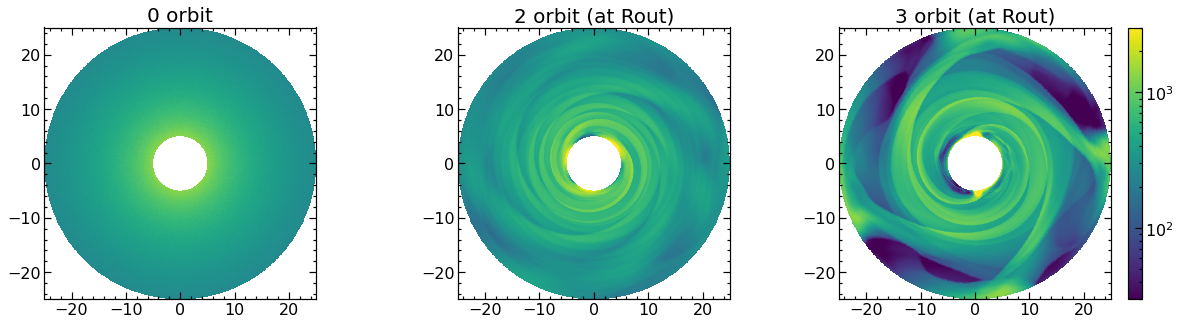

In [683]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
nums = [0, 20, 30]

for ax, num in zip((ax1, ax2, ax3), nums):
    sig = np.fromfile(Path(basedir,'gasdens{}.dat'.format(num))).reshape(Nrad, Nsec)
    theta, r = np.meshgrid(phif, Rf)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    img = ax.pcolormesh(x, y, sig*usurf, norm=LogNorm(3e1,3e3))
    ax.set_aspect('equal')
plt.colorbar(img)
ax1.set_title('0 orbit')
ax2.set_title('2 orbit (at Rout)')
ax3.set_title('3 orbit (at Rout)')